In [1]:
# gaussian blur test

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
import json

# Before running
Make sure the data set from `import_pictures.ipynb` is not already modified by one of those things, cause that would make ugly results.

In [4]:
# load image data, remove class and reshape 
data = pd.read_pickle('../data/images_df_numerical.pkl')
X, y = data['data'], data['Species']
X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)
image_size = X[0].size
samples = X.size
with open("../data/meta.json","r") as file:  # get metadata for images from file generated from import nb
    image_meta = json.load(file) 
image_shape = (image_meta['h'],image_meta['w'],image_meta['c']) # hwc
print("Image has shape", image_shape)
X = X.reshape((-1,) + image_shape)


Image has shape (82, 128, 4)


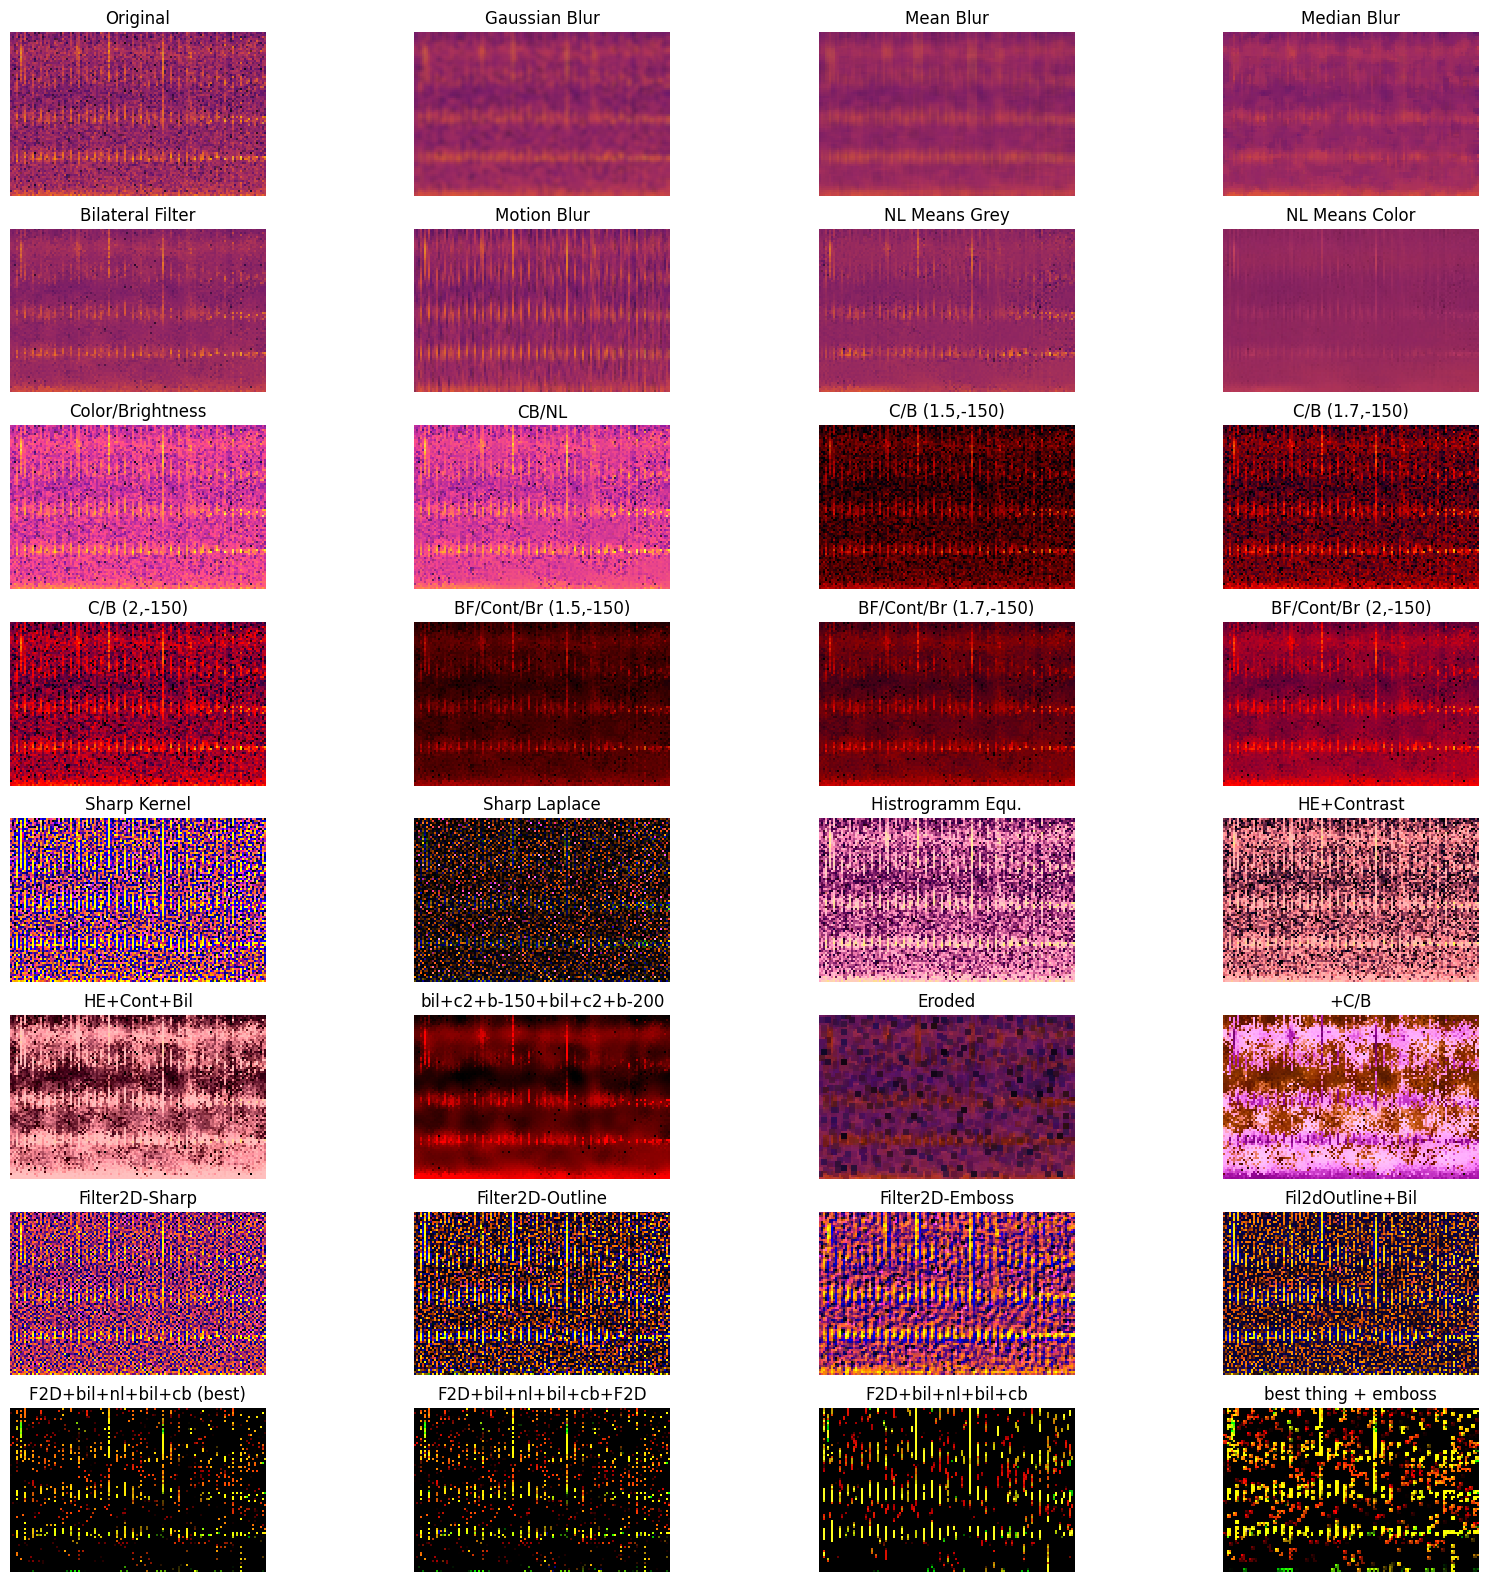

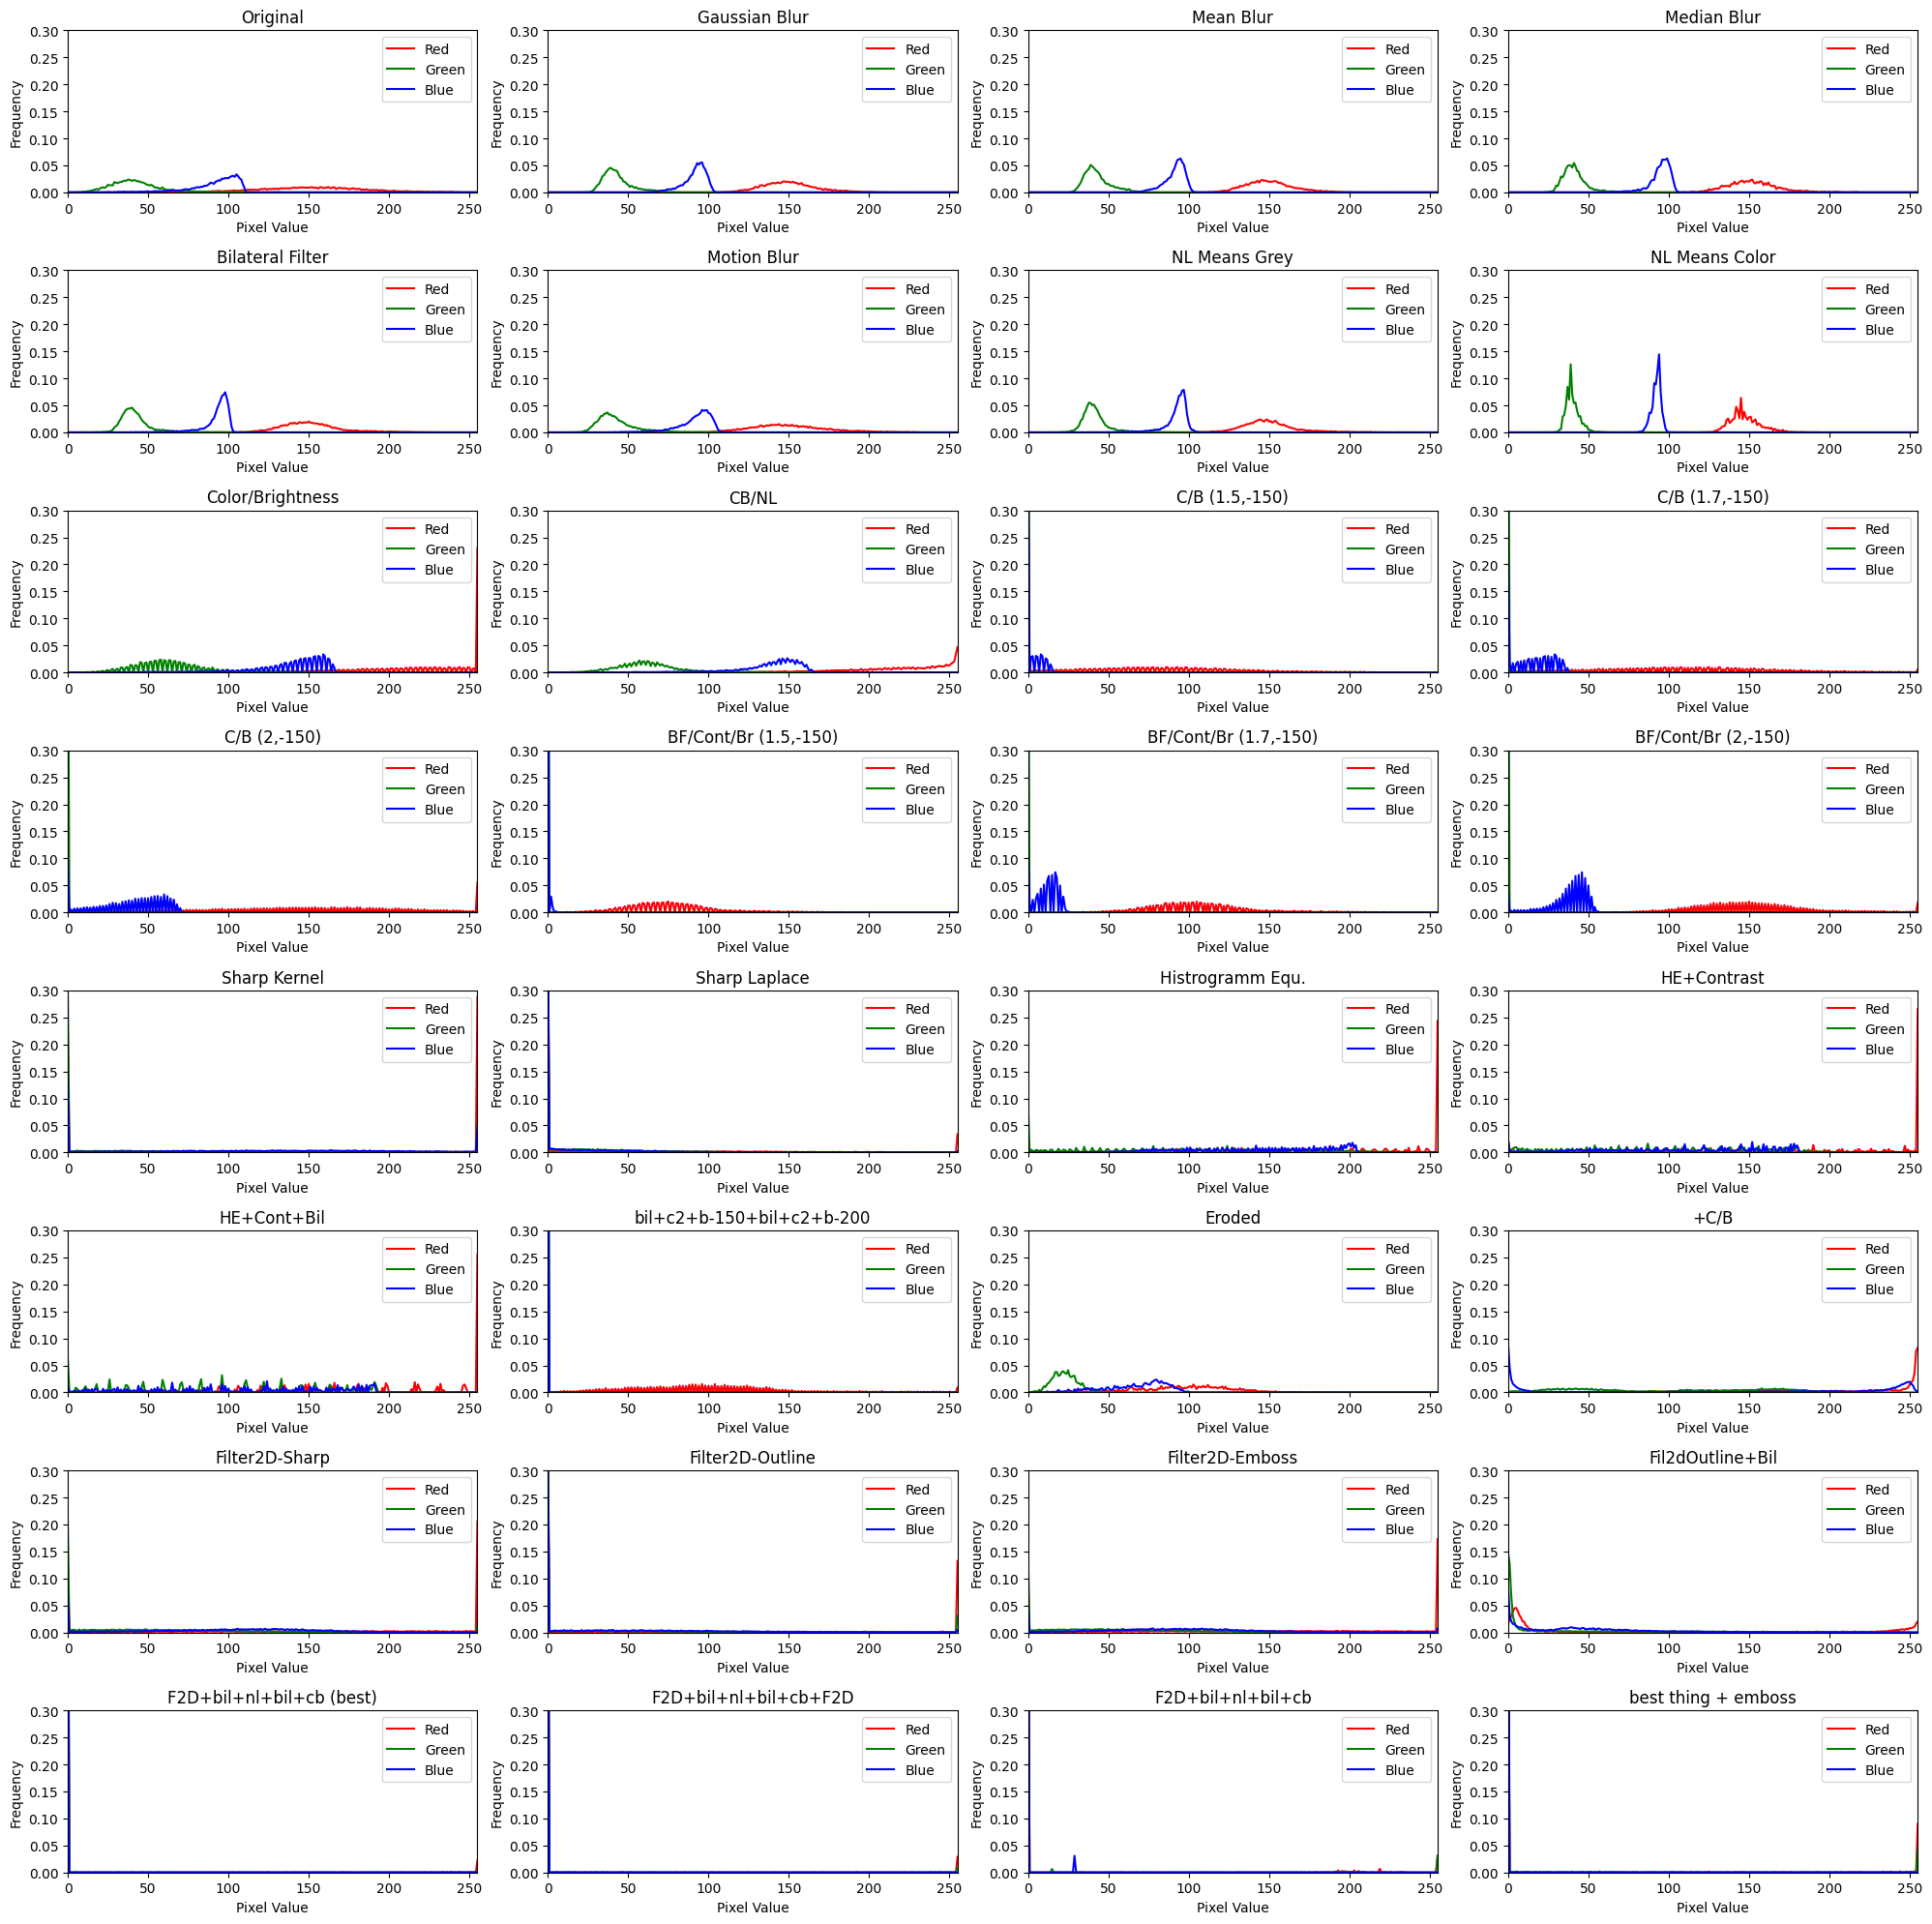

In [6]:
##### spektrogramme anzeigen
def show_images(images, titles):
    plt.figure(figsize=(20, 20))
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(8, 4, i)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.savefig("denoise_comaprison.png")
    plt.show()

# color distribution to show differences in intesities etc
def show_hist(images, titles):
    plt.figure(figsize=(20, 20))
    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(8, 4, i)
        plt.title(title)
        #plt.axis('off')
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        hist_r = cv2.calcHist([image_rgb], [0], None, [256], [0, 256]) / (image_size/3)
        hist_g = cv2.calcHist([image_rgb], [1], None, [256], [0, 256]) / (image_size/3)
        hist_b = cv2.calcHist([image_rgb], [2], None, [256], [0, 256]) / (image_size/3)

        plt.plot(hist_r, color='red', label='Red')
        plt.plot(hist_g, color='green', label='Green')
        plt.plot(hist_b, color='blue', label='Blue')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.xlim([0, 255])
        plt.ylim([0, 0.3])
    plt.tight_layout()
    plt.savefig("denoise_comaprison_hist.png")
    plt.show()

# Laden eines Beispielbildes
image = cv2.cvtColor(X[0],cv2.COLOR_BGRA2BGR)

# Gaußscher Weichzeichner
gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)

# Mittelwertfilter
mean_blur = cv2.blur(image, (5, 5))

# Medianfilter
median_blur = cv2.medianBlur(image, 5)

# Bilateralfilter
bilateral_blur = cv2.bilateralFilter(image, 9, 75, 75)

# Bewegungsunschärfe
kernel_motion_blur = np.zeros((5, 5))
kernel_motion_blur[:, int((5-1)/2)] = 1
kernel_motion_blur /= 5
motion_blur = cv2.filter2D(image, -1, kernel_motion_blur)

# predcit based on autoencoder
#autoencoder = keras.saving.load_model('../autoencoder_files/autoencoder_cnn_denoise_v7.keras')
#imagelist = np.asarray([image]).astype('float32')/255.
#autoencoder_img = (autoencoder.predict(imagelist)[0]*255.).astype('uint8')

# nl means denosing gray
fast_nl_grey = cv2.fastNlMeansDenoising(image, None, h=15, templateWindowSize=7, searchWindowSize=21)

# nl means denosing color
fast_nl_color = cv2.fastNlMeansDenoisingColored(image, None, 15,15, templateWindowSize=7, searchWindowSize=21)

# contrast/birghness
brightness = 1 
contrast = 1.5
c_b = cv2.addWeighted(image, contrast, np.zeros(image.shape, image.dtype), 0, brightness)


# cb + nlmeans
brightness = 0 
contrast = 1.5
cb_nl = cv2.fastNlMeansDenoising(cv2.addWeighted(image, contrast, np.zeros(image.shape, image.dtype), 0, brightness), None, h=15, templateWindowSize=7, searchWindowSize=21)


# + cont
cont1 = cv2.addWeighted(image, 1.5, np.zeros(image.shape, image.dtype), 0, -150)

cont2 = cv2.addWeighted(image, 1.7, np.zeros(image.shape, image.dtype), 0, -150)

cont3 = cv2.addWeighted(image, 2, np.zeros(image.shape, image.dtype), 0, -150)

# bil + cont
img = cv2.bilateralFilter(image, 9, 75, 75)
bil_cont1 = cv2.addWeighted(img, 1.5, np.zeros(img.shape, img.dtype), 0, -150)

img = cv2.bilateralFilter(image, 9, 75, 75)
bil_cont2 = cv2.addWeighted(img, 1.7, np.zeros(img.shape, img.dtype), 0, -150)

img = cv2.bilateralFilter(image, 9, 75, 75)
bil_cont3 = cv2.addWeighted(img, 2, np.zeros(img.shape, img.dtype), 0, -150)

# bil+c2+b-150+bil+c2+b-200
img = cv2.bilateralFilter(image, 9, 75, 75)
img = cv2.addWeighted(img, 2, np.zeros(img.shape, img.dtype), 0, -150)
img = cv2.bilateralFilter(img, 9, 75, 75)
bl_cb_bil_cb1 = cv2.addWeighted(img, 2, np.zeros(img.shape, img.dtype), 0, -200)

#sharpen kernel
kernel = np.array([[-1, -1, -1],
                       [-1, 9, -1],
                       [-1, -1, -1]])
sharp_img = cv2.filter2D(image, -1, kernel)

#sharpen laplace
sharp_lapla = cv2.Laplacian(image, cv2.CV_8U) 

# equ hist
img = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
img[:,:,0] = cv2.equalizeHist(img[:,:,0])
equ_hist1 = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)

# equ hist + contrast
img = cv2.addWeighted(image, 1.7, np.zeros(image.shape, image.dtype), 0, -150)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
img[:,:,0] = cv2.equalizeHist(img[:,:,0])
equ_hist2 = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)

# equ hist + contrast + bilateral
img = cv2.bilateralFilter(image, 9, 75, 75)
img = cv2.addWeighted(img, 1.7, np.zeros(img.shape, img.dtype), 0, -150)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
img[:,:,0] = cv2.equalizeHist(img[:,:,0])
equ_hist3 = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)

# erode
kernel = np.array([[1, 9, 1],
                   [1, 9, 1],
                   [1, 9, 1]])
eroded1 = cv2.erode(image, kernel)

# c/b + equ hsit + bil
img = cv2.addWeighted(img, 2, np.zeros(img.shape, img.dtype), 0, -100)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
img[:,:,0] = cv2.equalizeHist(img[:,:,0])
img = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)
eroded2 = cv2.bilateralFilter(img, 9, 75, 75)

# filter 2d sharp
kernel = np.array([[0, -1, 0],
                  [-1, 5, -1],
                  [0, -1, 0]])
filter2d_1 = cv2.filter2D(image,-1,kernel)

# filter 2d outline
kernel = np.array([
  [-1, -1, -1],
  [-1, 8, -1],
  [-1, -1, -1]
])
filter2d_2 = cv2.filter2D(image,-1,kernel)

# filter 2d emboss
kernel = np.array([
  [-2, -1, 0],
  [-1, 1, 1],
  [0, 1, 2]
])
filter2d_3 = cv2.filter2D(image,-1,kernel)

#filter2d outline + bil
kernel = np.array([
  [-1, -1, -1],
  [-1, 8, -1],
  [-1, -1, -1]
])
img = cv2.filter2D(image,-1,kernel)
fil_bil1 = cv2.bilateralFilter(img, 9, 75, 75)

#filter2d (-1/7)+ bil + nl + bil + c1.7/b-150  (best thing yet)
kernel = np.array([
  [-1, -1, -1],
  [-1, 7, -1],
  [-1, -1, -1]
])
#img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
img = cv2.filter2D(image,-1,kernel)
img = cv2.bilateralFilter(img, 9, 75, 75)
img = cv2.fastNlMeansDenoising(img, None, h=15, templateWindowSize=7, searchWindowSize=21)
img = cv2.bilateralFilter(img, 9, 75, 75)
fil_nl1 = cv2.addWeighted(img, 1.7, np.zeros(img.shape, img.dtype), 0, -150)

#filter2d (-1/7)+ bil + nl + c1.7/b-150 (okay)
kernel = np.array([
  [-1, -1, -1],
  [-1, 7, -1],
  [-1, -1, -1]
])
img = cv2.filter2D(image,-1,kernel)
img = cv2.bilateralFilter(img, 9, 75, 75)
img = cv2.fastNlMeansDenoising(img, None, h=15, templateWindowSize=7, searchWindowSize=21)
fil_nl2 = cv2.addWeighted(img, 1.7, np.zeros(img.shape, img.dtype), 0, -150)

#filter2d (outline)+ bil + nl + c1.7/b-150 + f2d (sobel)
kernel = np.array([
  [-1, -1, -1],
  [-1, 7, -1],
  [-1, -1, -1]
])
img = cv2.filter2D(image,-1,kernel)
img = cv2.bilateralFilter(img, 9, 75, 75)
img = cv2.fastNlMeansDenoising(img, None, h=15, templateWindowSize=7, searchWindowSize=21)
img = cv2.bilateralFilter(img, 9, 75, 75)
img = cv2.addWeighted(img, 1.7, np.zeros(img.shape, img.dtype), 0, -150)
kernel = np.array([
  [-1, 0, 1],
  [-2, 0, 2],
  [-1, 0, 1]
])
img = cv2.filter2D(img,-1,kernel)
img = cv2.bilateralFilter(img, 9, 75, 75)
img = cv2.addWeighted(img, 1.7, np.zeros(img.shape, img.dtype), 0, -150)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
img[:,:,0] = cv2.equalizeHist(img[:,:,0])
fil_nl3 = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)

# best thing + emboss
kernel = np.array([
  [-1, -1, -1],
  [-1, 7, -1],
  [-1, -1, -1]
])
img = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
img = cv2.filter2D(img,-1,kernel)
img = cv2.bilateralFilter(img, 9, 75, 75)
img = cv2.fastNlMeansDenoising(img, None, h=15, templateWindowSize=7, searchWindowSize=21)
img = cv2.bilateralFilter(img, 9, 75, 75)
img = cv2.addWeighted(img, 1.7, np.zeros(img.shape, img.dtype), 0, -150)
kernel = np.array([
  [-2, -1, 0],
  [-1, 1, 1],
  [0, 1, 2]
])
fil_nl4 = cv2.filter2D(img,-1,kernel)

list = ([image, gaussian_blur, mean_blur, median_blur, bilateral_blur, motion_blur,fast_nl_grey,fast_nl_color,
         c_b,cb_nl,cont1,cont2,cont3,bil_cont1,bil_cont2,bil_cont3,sharp_img,sharp_lapla,equ_hist1,equ_hist2,
         equ_hist3,bl_cb_bil_cb1,eroded1, eroded2,filter2d_1,filter2d_2,filter2d_3,fil_bil1,fil_nl1,fil_nl2,fil_nl3,
         fil_nl4
        ],
        ['Original', 'Gaussian Blur', 'Mean Blur', 'Median Blur', 'Bilateral Filter', 'Motion Blur','NL Means Grey',
         'NL Means Color','Color/Brightness','CB/NL','C/B (1.5,-150)','C/B (1.7,-150)','C/B (2,-150)',
         'BF/Cont/Br (1.5,-150)', 'BF/Cont/Br (1.7,-150)', 'BF/Cont/Br (2,-150)', 'Sharp Kernel', 'Sharp Laplace',
         'Histrogramm Equ.', 'HE+Contrast', 'HE+Cont+Bil', "bil+c2+b-150+bil+c2+b-200", "Eroded", "+C/B", 'Filter2D-Sharp',
         "Filter2D-Outline", "Filter2D-Emboss", "Fil2dOutline+Bil", "F2D+bil+nl+bil+cb (best)", "F2D+bil+nl+bil+cb+F2D",
         "F2D+bil+nl+bil+cb", "best thing + emboss"])

# Anzeigen der Ergebnisse
show_images(*list)
show_hist(*list)



In [ ]:
##### import cv2

def compare_histograms(images, titles):
    num_images = len(images)

    # Load the original image
    original_image = data[0]
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    hist_original_r = cv2.calcHist([original_image_rgb], [0], None, [256], [0, 256])
    hist_original_g = cv2.calcHist([original_image_rgb], [1], None, [256], [0, 256])
    hist_original_b = cv2.calcHist([original_image_rgb], [2], None, [256], [0, 256])

    # Initialize lists to store individual channel scores
    correlation_scores = []
    chi_square_scores = []
    intersection_scores = []
    bhattacharyya_scores = []

    for i, (image_path, title) in enumerate(zip(images[1:], titles[1:]), 1):
        # Load the current image
        current_image = image_path
        current_image_rgb = cv2.cvtColor(current_image, cv2.COLOR_BGR2RGB)

        # Calculate histograms for the current image
        hist_current_r = cv2.calcHist([current_image_rgb], [0], None, [256], [0, 256])
        hist_current_g = cv2.calcHist([current_image_rgb], [1], None, [256], [0, 256])
        hist_current_b = cv2.calcHist([current_image_rgb], [2], None, [256], [0, 256])

        # Calculate histogram comparison metrics for each channel
        correlation_r = cv2.compareHist(hist_original_r, hist_current_r, cv2.HISTCMP_CORREL)
        chi_square_r = cv2.compareHist(hist_original_r, hist_current_r, cv2.HISTCMP_CHISQR)
        intersection_r = cv2.compareHist(hist_original_r, hist_current_r, cv2.HISTCMP_INTERSECT)
        bhattacharyya_r = cv2.compareHist(hist_original_r, hist_current_r, cv2.HISTCMP_BHATTACHARYYA)

        correlation_g = cv2.compareHist(hist_original_g, hist_current_g, cv2.HISTCMP_CORREL)
        chi_square_g = cv2.compareHist(hist_original_g, hist_current_g, cv2.HISTCMP_CHISQR)
        intersection_g = cv2.compareHist(hist_original_g, hist_current_g, cv2.HISTCMP_INTERSECT)
        bhattacharyya_g = cv2.compareHist(hist_original_g, hist_current_g, cv2.HISTCMP_BHATTACHARYYA)

        correlation_b = cv2.compareHist(hist_original_b, hist_current_b, cv2.HISTCMP_CORREL)
        chi_square_b = cv2.compareHist(hist_original_b, hist_current_b, cv2.HISTCMP_CHISQR)
        intersection_b = cv2.compareHist(hist_original_b, hist_current_b, cv2.HISTCMP_INTERSECT)
        bhattacharyya_b = cv2.compareHist(hist_original_b, hist_current_b, cv2.HISTCMP_BHATTACHARYYA)

        # Calculate average scores for each metric
        avg_correlation = (correlation_r + correlation_g + correlation_b) / 3
        avg_chi_square = (chi_square_r + chi_square_g + chi_square_b) / 3
        avg_intersection = (intersection_r + intersection_g + intersection_b) / 3
        avg_bhattacharyya = (bhattacharyya_r + bhattacharyya_g + bhattacharyya_b) / 3

        # Append the average scores to the lists
        correlation_scores.append(avg_correlation)
        chi_square_scores.append(avg_chi_square)
        intersection_scores.append(avg_intersection)
        bhattacharyya_scores.append(avg_bhattacharyya)

    # Print the average scores
    # in nem dataframe:
    scores = pd.DataFrame({'Image':titles[1:],'Correlation':correlation_scores,'Chi-Square':chi_square_scores,'Intersection':intersection_scores,'Bhattacharyya':bhattacharyya_scores})
    print(scores)
    #print best values
    # best values: 
    #   Correlation: 1
    #   Chi-Square: 0
    #   Intersection: +infinity
    #   Bhattacharyya: 1
    print("Best Correlation:")
compare_histograms([image, gaussian_blur, mean_blur, median_blur, bilateral_blur, motion_blur,predicted_image,denoised_image],
            ['Original', 'Gaussian Blur', 'Mean Blur', 'Median Blur', 'Bilateral Filter', 'Motion Blur', 'Autoencoder','NL Means Denoisng'])
